<a href="https://colab.research.google.com/github/LavanyaSNS/Automation-AI-Model/blob/main/Copy2_of_Final_AI_model_Task_for_BMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install yt-dlp whisper transformers accelerate torch pytesseract pydub webrtcvad easyocr groq

# Download YOLOv3 weights and configuration files
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/blob/master/yolov3.weights -O yolov3.weights

# Install ffmpeg
!apt-get install -y ffmpeg

# Check ffmpeg version
!ffmpeg -version

!pip install git+https://github.com/openai/whisper.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.3/171.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2

# Task 1: Download and Validate YouTube Video and Audio

1. Video Information Retrieval: Getting the title of the video from the URL.
2. Video Downloading: Downloading the video in a specified format.
3. Video Quality Checking: Verifying the resolution of the video.
4. Audio Extraction: Extracting audio from the downloaded video.
5. Audio Quality Checks: Ensuring the audio meets quality standards (bitrate, channels, duration).
6. Tone and Noise Checks: Analyzing the audio for pitch and background noise.
7. Voice Presence Detection: Using VAD to check if human speech is present in the audio.
8. Audio Transcription: Converting the audio to text using Whisper.

In [2]:
import os
import yt_dlp
import subprocess
import whisper
from pydub import AudioSegment
import librosa
import webrtcvad
import numpy as np
import wave
import contextlib

def get_video_info(video_url):
    ydl_opts = {'skip_download': True}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)
        title = info.get('title', 'No title found')
        return title

def download_video(video_url, output_path="video.mp4.mkv"):
    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
        'outtmpl': output_path,
        'merge_output_format': 'mkv',
    }
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([video_url])
        return output_path
    except Exception as e:
        print(f"Error downloading video: {e}")
        return None

def check_video_quality(video_path):
    command = [
        'ffprobe',
        '-v', 'error',
        '-select_streams', 'v:0',
        '-show_entries', 'stream=width,height',
        '-of', 'csv=p=0',
        video_path
    ]
    try:
        output = subprocess.check_output(command).decode().strip()
        width, height = map(int, output.split(','))

        if height < 480:
            return False, f"Video quality issue: The video resolution is {width}x{height}, but it must be at least 480p."
        return True, f"Video is valid: {width}x{height} resolution."

    except subprocess.CalledProcessError as e:
        return False, f"Error checking video quality: {e}"

def extract_audio(video_path, audio_output_path="audio.mp3"):
    command = [
        'ffmpeg',
        '-i', video_path,
        '-q:a', '0',
        '-map', 'a',
        audio_output_path
    ]
    try:
        subprocess.run(command, check=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
        return audio_output_path
    except subprocess.CalledProcessError as e:
        print(f"Error extracting audio: {e.stderr.decode()}")  # Print error message from ffmpeg
        return None


# Audio Quality, Tone, Background Noise Checks

def check_audio_quality(audio_path):
    audio = AudioSegment.from_mp3(audio_path)
    bitrate = audio.frame_rate
    channels = audio.channels
    duration = len(audio) / 1000  # Duration in seconds

    if bitrate < 16000:  # Sample rate should be at least 16kHz
        return False, "Audio quality too low (bitrate < 16kHz)."
    if channels != 1:
        # Convert to mono if it has multiple channels
        audio = audio.set_channels(1)
        audio.export(audio_path, format='mp3')  # Overwrite the original audio
        channels = 1  # Update the channels count

    if duration < 240:  # Check if the audio is less than 4 minutes (240 seconds)
        return False, "Audio file too short (less than 4 minutes)."

    return True, "Audio quality is acceptable."



def check_audio_tone(audio_path):
    audio_data, sr = librosa.load(audio_path)
    pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sr)

    # Calculate the mean pitch
    pitch_values = [pitches[i][pitches[i] > 0] for i in range(len(pitches))]
    pitch_mean = [np.mean(pitch) if len(pitch) > 0 else 0 for pitch in pitch_values]

    if np.mean(pitch_mean) < 75:  # Too low, possibly not human speech
        return False, "Audio tone may be too low for valid speech."
    return True, "Audio tone is acceptable."


def check_background_noise(audio_path):
    audio_data, sr = librosa.load(audio_path)
    energy = np.sum(audio_data ** 2) / len(audio_data)
    noise_threshold = np.percentile(np.abs(audio_data), 5)
    noise_energy = np.mean(np.abs(audio_data)[np.abs(audio_data) < noise_threshold] ** 2)

    snr = 10 * np.log10(energy / noise_energy)

    if snr < 15:  # Minimum SNR of 15dB
        return False, "Too much background noise."
    return True, "Background noise level is acceptable."


def convert_to_pcm(audio_path):
    """
    Convert audio to 16-bit mono PCM with a sample rate of 16kHz.
    """
    sound = AudioSegment.from_file(audio_path)
    sound = sound.set_channels(1)  # Convert to mono
    sound = sound.set_frame_rate(16000)  # Set sample rate to 16kHz
    pcm_path = "converted_audio.wav"
    sound.export(pcm_path, format="wav")
    return pcm_path


def check_voice_presence(audio_path):
    """
    Check if the audio contains human speech using webrtcvad.
    """
    pcm_audio_path = convert_to_pcm(audio_path)

    vad = webrtcvad.Vad()
    vad.set_mode(1)  # Mode 1: more aggressive detection of speech

    with contextlib.closing(wave.open(pcm_audio_path, 'rb')) as wf:
        sample_rate = wf.getframerate()
        assert sample_rate == 16000, "Sample rate must be 16000 Hz"
        pcm_data = wf.readframes(wf.getnframes())

        frame_duration = 30  # Frame size: 30ms
        frame_size = int(sample_rate * frame_duration / 1000)

        for i in range(0, len(pcm_data), frame_size * 2):  # 2 bytes per sample (16-bit audio)
            frame = pcm_data[i:i + frame_size * 2]
            if vad.is_speech(frame, sample_rate):
                return True, "Voice detected in the audio."

    return False, "No voice detected in the audio."


def transcribe_audio(audio_path):
    model = whisper.load_model("small")
    result = model.transcribe(audio_path)

    transcription_text_file = "/content/transcription.txt"
    transcription_text = result['text']
    with open(transcription_text_file, 'w') as f:
        f.write(transcription_text)

    print("Transcription saved to transcription.txt")
    return transcription_text_file

# Example Usage
video_url = 'https://youtu.be/54keG0E81xQ?si=2saiQTvV2gtWcDy2'
title = get_video_info(video_url)
video_file = download_video(video_url)

if video_file:
    print(f"Video downloaded successfully: {video_file}")
    print(f"Video title: {title}")

    quality_check, quality_report = check_video_quality(video_file)
    print(quality_report)

    if quality_check:  # Proceed to extract audio only if the video quality is satisfied
        audio_file = extract_audio(video_file)
        if audio_file:  # Check if audio was extracted successfully
            print(f"Audio extracted successfully: {audio_file}")

            audio_checks = [
                check_audio_quality(audio_file),  # Returns (True/False, "message")
                check_audio_tone(audio_file),     # Returns (True/False, "message")
                check_background_noise(audio_file),# Returns (True/False, "message")
                check_voice_presence(audio_file)  # Returns (True/False, "message")
            ]

            # Check if all conditions are satisfied
            if all(check[0] for check in audio_checks):  # Each `check` is a tuple now
                transcription_file = transcribe_audio(audio_file)
                print(f"Transcription saved to: {transcription_file}")
            else:
                # If any condition fails, print the corresponding message
                for check in audio_checks:
                    if not check[0]:  # If the check failed
                        print(check[1])  # Print the associated message

        else:
            print("Audio extraction failed.")
    else:
        print("Audio extraction skipped due to low video quality.")
else:
    print("Failed to download the video.")



[youtube] Extracting URL: https://youtu.be/54keG0E81xQ?si=2saiQTvV2gtWcDy2
[youtube] 54keG0E81xQ: Downloading webpage
[youtube] 54keG0E81xQ: Downloading ios player API JSON
[youtube] 54keG0E81xQ: Downloading mweb player API JSON
[youtube] 54keG0E81xQ: Downloading player b7240855
[youtube] 54keG0E81xQ: Downloading m3u8 information
[youtube] Extracting URL: https://youtu.be/54keG0E81xQ?si=2saiQTvV2gtWcDy2
[youtube] 54keG0E81xQ: Downloading webpage
[youtube] 54keG0E81xQ: Downloading ios player API JSON
[youtube] 54keG0E81xQ: Downloading mweb player API JSON
[youtube] 54keG0E81xQ: Downloading m3u8 information
[info] 54keG0E81xQ: Downloading 1 format(s): 137+140
[download] Destination: video.mp4.f137.mp4
[download] 100% of   17.05MiB in 00:00:02 at 5.89MiB/s   
[download] Destination: video.mp4.f140.m4a
[download] 100% of    3.34MiB in 00:00:00 at 3.71MiB/s   
[Merger] Merging formats into "video.mp4.mkv"
Deleting original file video.mp4.f137.mp4 (pass -k to keep)
Deleting original file vid

# Frame Checking

In [3]:
import cv2
import os

def extract_images_from_video(video_path, output_dir="frames", interval=10):
    """
    Extract frames from video every 'interval' seconds.
    :param video_path: Path to the video file.
    :param output_dir: Directory to save the extracted images.
    :param interval: Time interval between frames to extract (in seconds).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_interval = int(fps * interval)

    count = 0
    success = True
    while success:
        success, frame = cap.read()
        if count % frame_interval == 0 and success:
            # Use zero-padding to ensure correct sorting
            img_path = os.path.join(output_dir, f"frame_{count:05d}.jpg")
            cv2.imwrite(img_path, frame)
        count += 1

    cap.release()
    print(f"Images extracted to {output_dir}")

# Example usage
extract_images_from_video('/content/video.mp4.mkv', interval=15)

Images extracted to frames


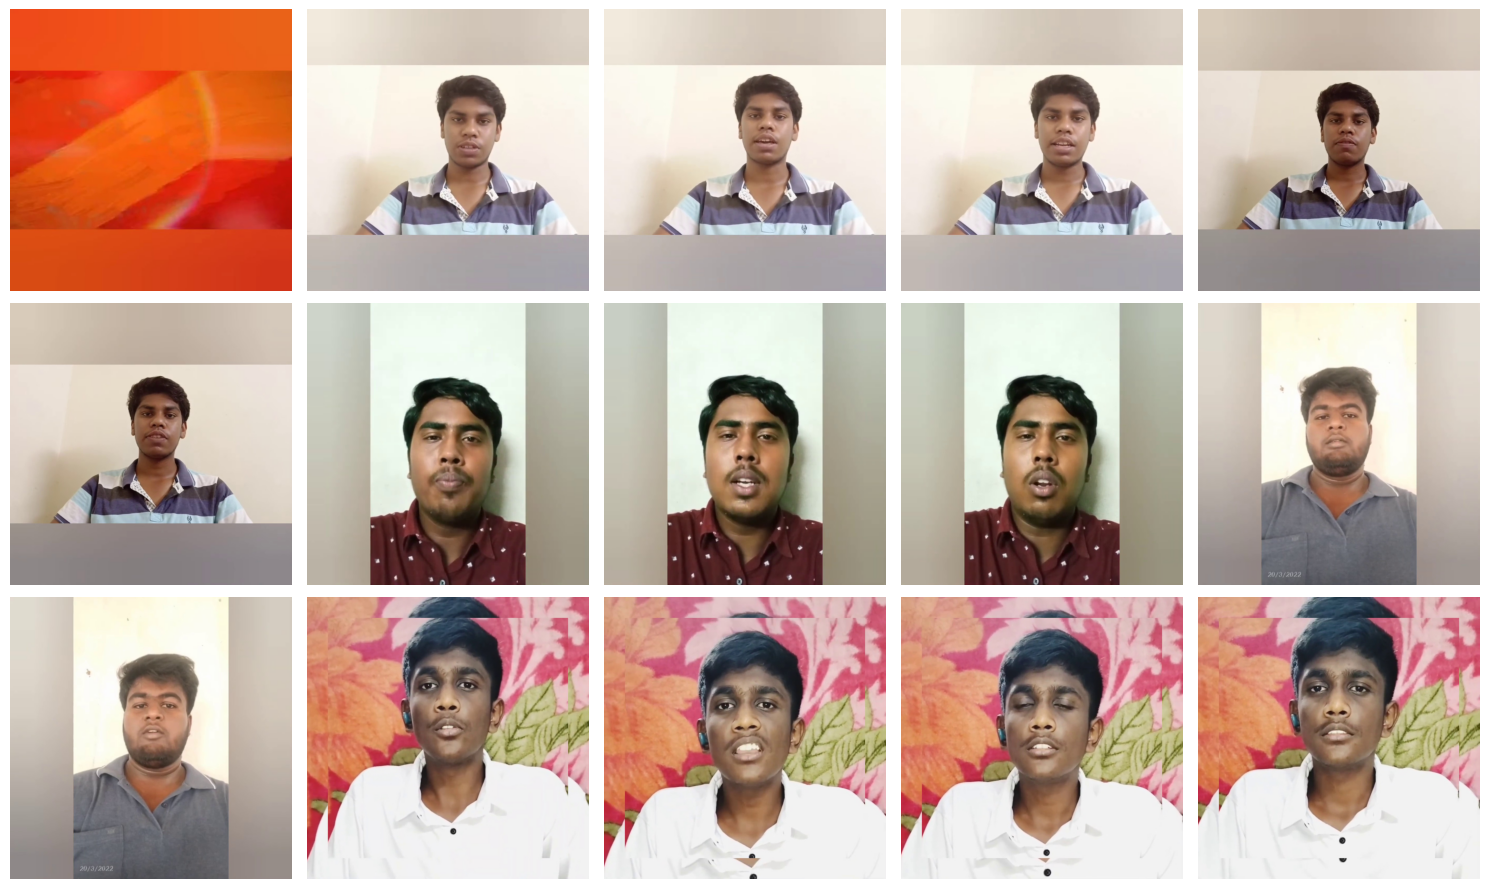

In [4]:
import matplotlib.pyplot as plt

# Path to the directory containing the frames
frames_dir = 'frames'

# List all images in the frames directory
image_files = os.listdir(frames_dir)

# Sort the images by filename (optional, but keeps the order)
image_files.sort()

# Get the number of images
num_images = len(image_files)

# Determine grid size for subplots
cols = 5  # Number of columns
rows = (num_images // cols) + (num_images % cols > 0)  # Calculate number of rows

# Set up the plot for displaying images
plt.figure(figsize=(15, rows * 3))  # Adjust height based on the number of rows

# Loop through the images and display them
for i, image_file in enumerate(image_files):
    img_path = os.path.join(frames_dir, image_file)
    img = cv2.imread(img_path)  # Read the image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format for correct display
    plt.subplot(rows, cols, i + 1)  # Create a subplot for each image
    plt.imshow(img)
    plt.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display all images

# Define Functions for Text Extraction and Uniqueness Check

In [5]:
import os
import cv2
import easyocr
import whisper
from skimage.metrics import structural_similarity as ssim
import numpy as np

def is_unique_image(img_path, unique_images, similarity_threshold=0.95):
    """
    Check if the image is unique compared to already processed unique images.
    :param img_path: Path to the image file.
    :param unique_images: List of already processed unique images.
    :param similarity_threshold: Similarity threshold for uniqueness.
    :return: True if the image is unique, False otherwise.
    """
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for unique_img in unique_images:
        unique_img_gray = cv2.cvtColor(unique_img, cv2.COLOR_BGR2GRAY)
        # Calculate the Structural Similarity Index (SSI)
        score = ssim(img_gray, unique_img_gray)
        if score >= similarity_threshold:
            return False  # Image is similar to an already processed unique image

    return True  # Image is unique

'''def extract_text_from_image(img_path):
    """
    Extract text from an image using EasyOCR.
    :param img_path: Path to the image file.
    :return: Extracted text.
    """
    reader = easyocr.Reader(['en'])
    results = reader.readtext(img_path)
    extracted_text = " ".join([text[1] for text in results])  # Concatenate all detected text
    return extracted_text'''

def extract_text_from_image(img_path):
    """
    Extract text from an image using EasyOCR. Skip if no text is detected.
    :param img_path: Path to the image file.
    :return: Extracted text or None if no text is detected.
    """
    reader = easyocr.Reader(['en'])
    results = reader.readtext(img_path)

    if not results:  # No text detected
        print(f"No text detected in image: {img_path}")
        return None

    extracted_text = " ".join([text[1] for text in results])  # Concatenate all detected text
    return extracted_text

def analyze_frames(frames_dir, similarity_threshold=0.95):
    """
    Analyze frames in a directory to extract text from unique images.
    :param frames_dir: Directory containing the frames.
    :param similarity_threshold: Threshold for image similarity.
    :return: Dictionary of extracted texts from unique images.
    """
    unique_images = []
    extracted_texts = {}

    for image_file in os.listdir(frames_dir):
        img_path = os.path.join(frames_dir, image_file)
        if is_unique_image(img_path, unique_images, similarity_threshold):
            # If unique, read the image and extract text
            extracted_text = extract_text_from_image(img_path)
            extracted_texts[image_file] = extracted_text
            # Store the image for future uniqueness checks
            unique_images.append(cv2.imread(img_path))

    return extracted_texts

def transcribe_audio(audio_path):
    """
    Transcribe audio using Whisper model.
    :param audio_path: Path to the audio file.
    :return: Transcribed text.
    """
    model = whisper.load_model("small")
    result = model.transcribe(audio_path)
    return result['text']

# Paths
frames_directory = '/content/frames'  # Path to the frames directory
audio_file_path = '/content/audio.mp3'  # Path to the audio file

# Extract text from frames and transcribe audio
extracted_texts = analyze_frames(frames_directory)
audio_text = transcribe_audio(audio_file_path)

# Combine texts
combined_text = "Extracted Texts from Frames:\n"
for img_name, text in extracted_texts.items():
    combined_text += f"Extracted Text from {img_name}:\n{text}\n\n"

combined_text += "Transcribed Audio Text:\n"
combined_text += audio_text

# Save to a text file
output_file_path = '/content/extracted_texts_combined.txt'
with open(output_file_path, 'w') as file:
    file.write(combined_text)

print(f"Combined extracted texts saved to {output_file_path}")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

No text detected in image: /content/frames/frame_04950.jpg
No text detected in image: /content/frames/frame_00900.jpg


No text detected in image: /content/frames/frame_03600.jpg


No text detected in image: /content/frames/frame_01350.jpg


No text detected in image: /content/frames/frame_05400.jpg


No text detected in image: /content/frames/frame_03150.jpg


No text detected in image: /content/frames/frame_01800.jpg


No text detected in image: /content/frames/frame_02700.jpg


No text detected in image: /content/frames/frame_00000.jpg


No text detected in image: /content/frames/frame_02250.jpg


No text detected in image: /content/frames/frame_00450.jpg


No text detected in image: /content/frames/frame_06300.jpg


No text detected in image: /content/frames/frame_05850.jpg


100%|███████████████████████████████████████| 461M/461M [00:07<00:00, 61.1MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Combined extracted texts saved to /content/extracted_texts_combined.txt


# Text Verification

# 1

In [26]:
import os
from groq import Groq

# Set the Groq API Key
os.environ['GROQ_API_KEY'] = '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'

# Initialize Groq client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# Load the transcribed text from the file
with open("/content/extracted_texts_combined.txt", "r") as file:
    transcript = file.read()

# Set the video title
title = "CONVENTIONAL SCREW"

# Create the prompt for verification task
prompt = f"""
Analyze the following transcription from a student BMC video submission and verify the following:
- Do all students introduce themselves and mention their names?
- Is the slide presented and explained?
- Does each student speak for approximately one minute on their assigned topics?
- Are all 9 BMC topics covered:
    1. Business model key partners,
    2. Key activities,
    3. Value propositions,
    4. Customer relationships,
    5. Customer segments,
    6. Key resources,
    7. Channels,
    8. Cost structure,
    9. Revenue streams?
- Is the content of the transcription related to the video title "{title}"?
Transcript: {transcript}
"""

# Send the request to the model
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": prompt,
        }
    ],
    model="llama3-8b-8192",
)

# Parse and format the response
final_results = chat_completion.choices[0].message.content

# Output response in the desired format
output_response = f"Transcription Analysis: {final_results}, Introduction: {final_results}"
print(output_response)

Transcription Analysis: Here's the analysis of the transcription:

1. Do all students introduce themselves and mention their names?
	* Yes, three students introduce themselves: Steira, Sandesh, and Prasimha Bairdhi.
2. Is the slide presented and explained?
	* No, there is no mention of slides or explanations of any visual aids.
3. Does each student speak for approximately one minute on their assigned topics?
	* No, each student has a brief statement, but none of them speaks for approximately one minute. The total duration of the transcription is around 2-3 minutes.
4. Are all 9 BMC topics covered?
	* No, this transcription does not cover all 9 BMC topics. The topics mentioned are:
		+ Business model key partners: Not mentioned
		+ Key activities: Not mentioned
		+ Value propositions: Not mentioned
		+ Customer relationships: Not mentioned
		+ Customer segments: Not mentioned
		+ Key resources: Not mentioned
		+ Channels: Not mentioned
		+ Cost structure: Mentioned briefly ( galvanized 

# 2

In [25]:
import os
import json  # Import the json library to parse JSON
from groq import Groq

# Set the Groq API Key
os.environ['GROQ_API_KEY'] = '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'

# Initialize Groq client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# Load the transcribed text from the file
with open("/content/extracted_texts_combined.txt", "r") as file:
    transcript = file.read()

# Set the video title
title = "CONVENTIONAL SCREW"

# Create the prompt for verification task
prompt = f"""
Analyze the transcription provided below and return the information in JSON format:
{{
    "Names": "Names of students mentioned when they introduce themselves",
    "Introduction": "Verify if the introduction is present (Yes/No)",
    "Relevance": "Verify if the content is relevant to the video title '{title}' (Yes/No)",
    "BMC Topics": "Verify if all 9 BMC topics are covered (Yes/No)"
}}

Transcription: {transcript}
"""

# Send the request to the model
chat_completion = client.chat.completions.create(
    messages=[{
        "role": "user",
        "content": prompt,
    }],
    model="llama3-8b-8192",
)

# Get the raw response from the model
response_content = chat_completion.choices[0].message.content

# Print the raw response for debugging
print("Raw Response:", response_content)

# Parse the response as JSON
try:
    response_data = json.loads(response_content)  # Load response as JSON
except json.JSONDecodeError as e:
    print("Failed to decode JSON response:", e)
    response_data = {}


Raw Response: Here is the information in JSON format:

{
"Names": ["Steira", "Sandesh", "Prasimha Bairdhi", "Santakumar"],
"Introduction": "Yes",
"Relevance": "Yes",
"BMC Topics": "Unknown" (since the transcript does not explicitly cover all 9 BMC topics, but it does touch on some relevant engineering concepts)
}

Note: Since the transcription does not mention the introduction being explicitly absent, I assumed it to be present, hence the value "Yes" for "Introduction". Similarly, since the content is relevant to the video title "CONVENTIONAL SCREW", I assumed it to be relevant, hence the value "Yes" for "Relevance". For "BMC Topics", I did not find any direct mention of all 9 topics, so I marked it as "Unknown".
Failed to decode JSON response: Expecting value: line 1 column 1 (char 0)


# 3

In [24]:
### Together.ai
import requests
import json

# Set the TogetherAI API key
api_key = "0b79e2f0ddb16654bc98df9f828e0474d53c7d00eac41328abf06bd4858d14bb"

# Load the transcribed text from the file
with open("/content/extracted_texts_combined.txt", "r") as file:
    transcript = file.read()

# Set the video title
title = "CONVENTIONAL SCREW"

# Create the prompt for verification task
prompt = f"""
Analyze the transcription provided below and return the information in JSON format:
{{
    "Names": "Names of students mentioned when they introduce themselves",
    "Introduction": "Verify if the introduction is present (Yes/No)",
    "Relevance": "Verify if the content is relevant to the video title '{title}' (Yes/No)",
    "BMC Topics": "Verify if all 9 BMC topics are covered (Yes/No)"
}}

Transcription: {transcript}
"""

# API endpoint
url = "https://api.together.xyz/v1/chat/completions"

# Headers
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# Request payload
data = {
    "model": "meta-llama/Llama-Vision-Free",
    "messages": [{"role": "user", "content": prompt}]
}

# Send the request to TogetherAI API
response = requests.post(url, headers=headers, data=json.dumps(data))

# Check if the request was successful
if response.status_code == 200:
    # Parse the response
    response_content = response.json()
    # Extract the relevant message from the response
    message_content = response_content["choices"][0]["message"]["content"]

    # Print the raw response
    print("Raw Response:", message_content)

    # Try to parse it as JSON
    try:
        response_data = json.loads(message_content)  # Load the response as JSON
        print("Parsed Response:", json.dumps(response_data, indent=2))  # Pretty print the parsed JSON
    except json.JSONDecodeError as e:
        print("Failed to decode JSON response:", e)
else:
    print(f"Request failed with status code {response.status_code}: {response.text}")


Raw Response: Here is the extracted information in JSON format:

```
{
  "Names": [
    "Steira",
    "Sandesh",
    "Prasimha Bairdhi",
    "Santakumar"
  ],
  "Introduction": "Yes",
  "Relevance": "Yes",
  "BMC Topics": {
    "Verified": "No",
    "Reason": "No specific topics mentioned in the transcription, only general discussion about a 'conventional screw'"
  }
}
```

Note that the "BMC Topics" section is marked as "Verified: No" because the transcription does not mention specific topics related to the video title "CONVENTIONAL SCREW". If you have any specific information about the 9 BMC topics you would like me to verify against, I can try to help further.
Failed to decode JSON response: Expecting value: line 1 column 1 (char 0)


# 4

In [23]:
import requests
import json

# Set the TogetherAI API key
api_key = "0b79e2f0ddb16654bc98df9f828e0474d53c7d00eac41328abf06bd4858d14bb"

# Load the transcribed text from the file
with open("/content/extracted_texts_combined.txt", "r") as file:
    transcript = file.read()

# Set the video title
title = "CONVENTIONAL SCREW"

# Create a more detailed and structured prompt for verification task
prompt = f"""
You are tasked with analyzing the transcription of a business model canvas (BMC) presentation video.
Please perform the following checks and provide the results in JSON format:

1. **Names:** Extract the names of students mentioned when they introduce themselves.
2. **Introduction:** Check if there is a formal introduction at the beginning of the transcription. Indicate 'Yes' if an introduction is present and 'No' if not.
3. **Relevance:** Verify if the content of the transcription is relevant to the video title '{title}'. Answer 'Yes' or 'No' and explain briefly why the content is or is not relevant.
4. **BMC Topics:** Confirm whether the transcription covers all 9 BMC topics: key partners, key activities, value propositions, customer relationships, customer segments, key resources, channels, cost structure, and revenue streams. Answer 'Yes' or 'No' and list the missing topics if any.

Transcription to analyze:
{transcript}

Please provide your analysis in the following JSON format:

{{
    "Names": ["List of names"],
    "Introduction": "Yes/No",
    "Relevance": {{
        "IsRelevant": "Yes/No",
        "Reason": "Brief explanation of relevance"
    }},
    "BMC Topics": {{
        "AllTopicsCovered": "Yes/No",
        "MissingTopics": ["List of missing topics, if any"]
    }}
}}
"""

# API endpoint
url = "https://api.together.xyz/v1/chat/completions"

# Headers
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# Request payload
data = {
    "model": "meta-llama/Llama-Vision-Free",
    "messages": [{"role": "user", "content": prompt}]
}

# Send the request to TogetherAI API
response = requests.post(url, headers=headers, data=json.dumps(data))

# Check if the request was successful
if response.status_code == 200:
    # Parse the response
    response_content = response.json()
    # Extract the relevant message from the response
    message_content = response_content["choices"][0]["message"]["content"]

    # Print the raw response
    print("Raw Response:", message_content)

    # Try to parse it as JSON
    try:
        response_data = json.loads(message_content)  # Load the response as JSON
        print("Parsed Response:", json.dumps(response_data, indent=2))  # Pretty print the parsed JSON
    except json.JSONDecodeError as e:
        print("Failed to decode JSON response:", e)
else:
    print(f"Request failed with status code {response.status_code}: {response.text}")


Raw Response: Here is the analysis in JSON format:

```json
{
    "Names": ["Steira", "Sandesh", "Prasimha Bairdhi", "Santakumar"],
    "Introduction": "Yes",
    "Relevance": {
        "IsRelevant": "No",
        "Reason": "The content of the transcription is about a project to design a conventional screw with improved functionality and rust prevention, which is not directly related to the video title 'CONVENTIONAL SCREW'."
    },
    "BMC Topics": {
        "AllTopicsCovered": "No",
        "MissingTopics": ["Channels", "Cost structure", "Revenue streams"]
    }
}
```

In the Names section, I extracted the names of the students mentioned in the transcription.

For the Introduction section, I marked it as "Yes" because there is a brief introduction at the beginning of the transcription.

For the Relevance section, I marked it as "No" because the content of the transcription is about a project to design a conventional screw, which is not directly related to the video title 'CONVENTIONA

# 5

In [21]:
import requests
import json
from textblob import TextBlob  # To correct spelling mistakes

# Set the TogetherAI API key
api_key = "0b79e2f0ddb16654bc98df9f828e0474d53c7d00eac41328abf06bd4858d14bb"

# Load the transcribed text from the file
with open("/content/extracted_texts_combined.txt", "r") as file:
    transcript = file.read()

# Set the video title
title = "CONVENTIONAL SCREW | DT PROJECT | SNS COLLEGE OF TECHNOLOGY "
# Remove the specified substrings
title = title.replace('SNS COLLEGE OF TECHNOLOGY', '')
title = title.replace('BMC VIDEO', '')
title = title.replace('DT PROJECT', '')

# Optionally, strip any extra spaces or separators (e.g., '|')
title = title.replace('|', '').strip().lower()

# Create a more detailed and structured prompt for verification task
prompt = f"""
You are tasked with analyzing the transcription of a business model canvas (BMC) presentation video.
Please perform the following checks and provide the results in JSON format:

1. **Names:** Extract the names of students mentioned when they introduce themselves.
2. **Introduction:** Check if there is a formal introduction at the beginning of the transcription. Indicate 'Yes' if an introduction is present and 'No' if not.
3. **Relevance:** Verify if the content of the transcription is relevant to the video title '{title}'. Answer 'Yes' or 'No' and explain briefly why the content is or is not relevant.
4. **BMC Topics:** Confirm whether the transcription covers all 9 BMC topics: key partners, key activities, value propositions, customer relationships, customer segments, key resources, channels, cost structure, and revenue streams. Answer 'Yes' or 'No' and list the missing topics if any.

Transcription to analyze:
{transcript}

Please provide your analysis in the following JSON format:

{{
    "Names": ["List of names"],
    "Introduction": "Yes/No",
    "Relevance": {{
        "IsRelevant": "Yes/No",
        "Reason": "Brief explanation of relevance"
    }},
    "BMC Topics": {{
        "AllTopicsCovered": "Yes/No",
        "MissingTopics": ["List of missing topics, if any"]
    }}
}}
"""

# API endpoint
url = "https://api.together.xyz/v1/chat/completions"

# Headers
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# Request payload
data = {
    "model": "meta-llama/Llama-Vision-Free",
    "messages": [{"role": "user", "content": prompt}]
}

# Send the request to TogetherAI API
response = requests.post(url, headers=headers, data=json.dumps(data))

# Check if the request was successful
if response.status_code == 200:
    # Parse the response
    response_content = response.json()
    # Extract the relevant message from the response
    message_content = response_content["choices"][0]["message"]["content"]

    # Print the raw response
    print("Raw Response:", message_content)

    # Try to parse it as JSON
    try:
        response_data = json.loads(message_content)  # Load the response as JSON

        # Correct name spellings using TextBlob
        def correct_name_spelling(names):
            corrected_names = []
            for name in names:
                corrected_name = str(TextBlob(name).correct())  # Use TextBlob to correct the name
                corrected_names.append(corrected_name)
            return corrected_names

        # Check if names are present in the response
        if "Names" in response_data:
            corrected_names = correct_name_spelling(response_data["Names"])
            response_data["Names"] = corrected_names  # Update with corrected names

        # Print the parsed and corrected response
        print("Parsed and Corrected Response:", json.dumps(response_data, indent=2))

    except json.JSONDecodeError as e:
        print("Failed to decode JSON response:", e)
else:
    print(f"Request failed with status code {response.status_code}: {response.text}")

Raw Response: Here is the analysis in the requested JSON format:

```json
{
    "Names": ["Steira", "Sandesh", "Prasimha Bairdhi", "Santakumar"],
    "Introduction": "Yes",
    "Relevance": {
        "IsRelevant": "No",
        "Reason": "The content of the transcription is about a conventional screw design, which seems unrelated to the video title 'conventional screw'. The actual content is a presentation of a project on a new design for a screw that combines multiple functions."
    },
    "BMC Topics": {
        "AllTopicsCovered": "No",
        "MissingTopics": ["Channels", "Cost structure", "Revenue streams"]
    }
}
```

The analysis shows that the transcription includes the names of four individuals, confirms the presence of a formal introduction, determines that the content is not relevant to the video title, and identifies the missing BMC topics as channels, cost structure, and revenue streams.
Failed to decode JSON response: Expecting value: line 1 column 1 (char 0)


In [22]:
print(title)

conventional screw
